In [1]:
from constants import *
from obfuscation import *
from run_obfuscation import * 
from data_utils import *
from stereo_utils import *
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
from pathlib import Path

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [14]:
dataset_files = list(read_dataset_to_obfuscate(f"{ROOT_DIR}/obfuscation/ml-1m"))
original_data = { data_slice:transform_to_obf(data) for data_slice,data in zip(['train','valid','test'],dataset_files)}


In [15]:
data_dir = f"{ROOT_DIR}/obfuscation/ml-1m"
def calculate_dataset_stereo(data_dir,stereo_typesSTER):
    train_data, valid_data, test_data, inclination_data, user_features, dataset_name  = read_dataset_to_obfuscate(data_dir)
    for stereo_type in stereo_types:
        user_stereo_scores = []
        for user  in user_features["userID"].values:        
            user_data, valid_user_items, user_ff_values, user_stereo_score = (ff_data=inclination_data,sterotyp_method=stereo_type,train_data=train_data,user=user)
            user_stereo_scores.append(user_stereo_score)
        user_features[f"stereo_{stereo_type}"] = user_stereo_scores
    return user_features
def read_dataset_stereo(data_dir):
    dataset_name = data_dir.split("/")[-1]
    return pd.read_csv(f"{data_dir}/{dataset_name}_user_ster.csv",index_col="userID")

In [21]:
train_data, valid_data, test_data, inclination_data, user_features, dataset_name = read_dataset_to_obfuscate(f"{ROOT_DIR}/obfuscation/ml-1m")
user_dataset=pd.concat([train_data,valid_data],ignore_index=True)
stereo_info = calc_all_user_stereotyp_pref(ff_data=inclination_data,user_dataset=user_dataset,sterotyp_methods=STEREO_TYPES)
stereo_info.to_csv(f"{ROOT_DIR}/obfuscation/ml-1m/ml-1m_all_user_ster.csv")

In [22]:
train_data, valid_data, test_data, inclination_data, user_features, dataset_name = read_dataset_to_obfuscate(f"{ROOT_DIR}/obfuscation/lfm-100k")
user_dataset=pd.concat([train_data,valid_data],ignore_index=True)
stereo_info = calc_all_user_stereotyp_pref(ff_data=inclination_data,user_dataset=user_dataset,sterotyp_methods=STEREO_TYPES)
stereo_info.to_csv(f"{ROOT_DIR}/obfuscation/lfm-100k/lfm-100k_all_user_ster.csv")

In [2]:
all_sters_dir = [f"{ROOT_DIR}/obfuscation/lfm-100k/lfm-100k_all_user_ster.csv",
 f"{ROOT_DIR}/obfuscation/ml-1m/ml-1m_all_user_ster.csv"]
df_all_ster = [pd.read_csv(x) for x in all_sters_dir]


lfm-100k ====================================================
            userID       median     mean-abs   median-abs           diff
count  9352.000000  9352.000000  9352.000000  9352.000000    9352.000000
mean   4681.554855     0.073735     0.390320     0.385694    5030.339981
std    2704.014513     0.301743     0.081508     0.101839   18112.856178
min       0.000000    -0.958360     0.058575     0.011504 -107408.000000
25%    2338.750000    -0.164372     0.343239     0.322174       6.000000
50%    4682.500000     0.096612     0.377499     0.372383     416.750000
75%    7023.250000     0.291854     0.423324     0.428792    3430.000000
max    9363.000000     0.901189     0.959567     0.958360  415313.500000
ml-1m ====================================================
            userID       median     mean-abs   median-abs           diff
count  6040.000000  6040.000000  6040.000000  6040.000000    6040.000000
mean   3020.500000     0.198596     0.302587     0.293497   12298.820613
std

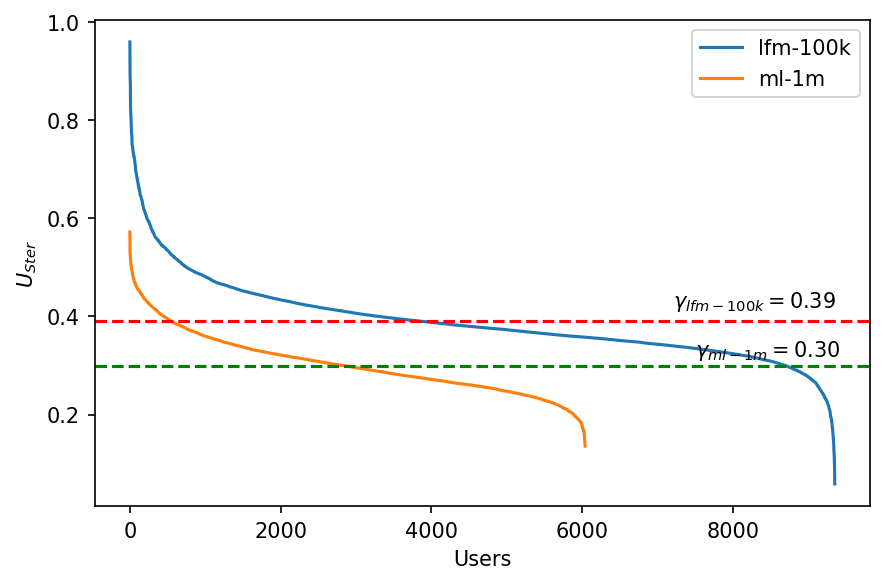

In [168]:
datasets = ["lfm-100k","ml-1m"]
fig = plt.figure(dpi=150)
handles = [plt.plot(df[df["mean-abs"]>=0].
                    sort_values("mean-abs",ascending=False)["mean-abs"].
                    reset_index(drop=True),) 
                    for l,df in zip(datasets,df_all_ster)]
plt.legend(labels=datasets)
plt.xlabel('Users', horizontalalignment='center')
plt.ylabel('$U_{Ster}$', horizontalalignment='center')
#[h.set(label=l)for l,h in zip(datasets,handles)]

[print(f'{dset} ====================================================\n{str(df[df["mean-abs"]>=0].describe())}') for dset,df in zip(datasets,df_all_ster)]

plt.axhline(0.3,c="g",linestyle="--" )
plt.axhline(0.39,c="r",linestyle="--" )

plt.text(x=7500,y=0.32,s="$\gamma_{ml-1m}=0.30$",fontdict=dict())
plt.text(x=7200,y=0.42,s="$\gamma_{lfm-100k}=0.39$",fontdict=dict())
plt.tight_layout()
plt.savefig("figures/user_ster_thresh.png")

In [153]:
def calc_max_delta_slope(data:pd.Series):
    slopes_up= np.zeros(len(data))
    slopes_down= np.zeros(len(data))
    slopes_down= (data.shift(-1,fill_value=0)-data)    
    slopes_up[1:] = slopes_down[:-1]
    delta_slopes = slopes_down-slopes_up
    delta_slopes.iloc[0]=-np.inf
    delta_slopes.iloc[-1]=-np.inf
    index_max_delta = np.argmax(delta_slopes)
    return index_max_delta, data[index_max_delta],delta_slopes,slopes_down,slopes_up

ster_data = [calc_max_delta_slope(df[df["mean-abs"]>=0]
             .sort_values(
                 "mean-abs",
                 ascending=False)
                 ["mean-abs"].reset_index(drop=True)
                 ) 
                 for l,df in zip(datasets,df_all_ster)]


|Score|slope right|slope left| delta slope|
|-----|-----|-----|----|
|0.26|-0.01| --  |--|	
|0.25|-0.05|-0.01|-0.04|
|0.2 |-0.09|-0.05|-0.04|
|0.11|-0.08|-0.09|0.01|
|0.03|-0.01|-0.08|0.07|
|0.02|--|--|--|	


In [140]:
[np.median(df[df["mean-abs"]>=0].
                    sort_values("mean-abs",ascending=False)["mean-abs"].
                    reset_index(drop=True),) 
                    for l,df in zip(datasets,df_all_ster)]

[0.37749894213245605, 0.2952153774834966]

In [146]:
[print(f'{dset} ==============\n{str(df[df["mean-abs"]>=0].describe().loc[["mean","50%"],"mean-abs"].T)}') for dset,df in zip(datasets,df_all_ster)]
#plt.axhline(0.3,c="g",linestyle="--" )

#plt.text(x=7500,y=0.35,s="$\gamma=0.3$\n threshold",fontdict=dict())


lfm-100k ==============
mean    0.390320
50%     0.377499
Name: mean-abs, dtype: float64
ml-1m ==============
mean    0.302587
50%     0.295215
Name: mean-abs, dtype: float64


[None, None]

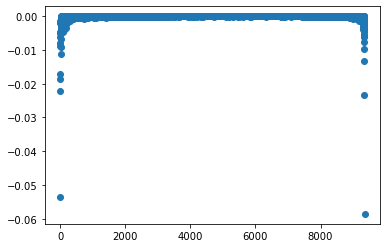

In [154]:
plt.scatter(np.arange(len(ster_data[0][-2])),ster_data[0][-2])

In [151]:
ster_data[0][2]

0           -inf
1       0.049041
2      -0.012315
3       0.015696
4      -0.004726
          ...   
9347   -0.004328
9348   -0.015652
9349    0.010131
9350    0.013277
9351        -inf
Name: mean-abs, Length: 9352, dtype: float64